In [1]:
import pandas as pd
import matplotlib.pyplot as plt                                         # A plotting library for creating static, interactive, and animated visualizations in Python
import matplotlib.ticker as ticker                                      # Provides classes for configuring tick locating and formatting
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt


### Initial loading and Duplication Check of the ABEA and Testing Dataset

In [2]:
# function to read the GRACE-formatted txt file into a df with a 'text' and 'label' column.
def grace_format_to_df_cols(txt_path):

    with open(txt_path, 'r') as file:
        file_content = file.read()

    content_without_docstart = file_content.split('\n', 1)[1]

    # Split the content based on empty lines to get each sequence
    sequences = [seq.strip() for seq in content_without_docstart.split('\n\n') if seq.strip()]

    texts_labels = [process_sequence(seq) for seq in sequences]
    texts, labels = zip(*texts_labels)  # Unzip the texts and labels

    df = pd.DataFrame({
        'text': texts,
        'label': labels
    })

    return df

# function to process each of the sequences
def process_sequence(seq):
    words = []
    labels = []
    char_index = 0  # Start from the first character
    in_label = False
    label_start = 0
    label_sentiment = ''

    for line in seq.split('\n'):
        parts = line.split()
        if len(parts) < 2:  # Skip empty lines or lines without tags
            continue
        word, tag = parts[0], parts[-1]
        words.append(word)

        # If this word starts a new label
        if 'B_AP' in tag:
            if in_label:  # End the previous label if starting a new one
                labels.append([label_start, char_index - 1, label_sentiment])
            in_label = True
            label_start = char_index
            # Determine the sentiment
            if 'HAPPINESS' in tag:
                label_sentiment = 'Happiness'
            elif 'ANGER' in tag:
                label_sentiment = 'Anger'
            elif 'FEAR' in tag:
                label_sentiment = 'Fear'
            elif 'SADNESS' in tag:
                label_sentiment = 'Sadness'
            elif 'NEGATIVE' in tag:
                label_sentiment = 'Negative'
            elif 'NEUTRAL' in tag:
                label_sentiment = 'Neutral'
            elif 'POSITIVE' in tag:
                label_sentiment = 'Positive'
            elif 'NONE' in tag:
                label_sentiment = 'None'


        # If this word is not part of a label or starts a new label
        if 'B_AP' not in tag and 'I_AP' not in tag and in_label:
            labels.append([label_start, char_index - 1, label_sentiment])
            in_label = False

        char_index += len(word) + 1  # Update character index for next word, adding 1 for the space

    # If the last label goes till the end of the sequence
    if in_label:
        labels.append([label_start, char_index - 1, label_sentiment])

    return ' '.join(words), labels

In [10]:
!git clone https://github.com/Christina1281995/thesis_abea.git
!cd thesis_abea

Cloning into 'thesis_abea'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 90 (delta 39), reused 87 (delta 39), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 32.33 MiB | 21.01 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [11]:
import os
print(os.listdir("GRACE/data"))

['new_abea', 'same_split_as_absa', 'original_absa']


In [12]:
if "same_split_as_absa" in os.listdir("GRACE/data"):
    print(os.listdir("GRACE/data/same_split_as_absa"))
else:
    print("پوشه same_split_as_absa وجود ندارد!")
    # بررسی سایر پوشه‌های احتمالی
    for folder in os.listdir("GRACE/data"):
        folder_path = os.path.join("GRACE/data", folder)
        if os.path.isdir(folder_path):
            print(f"محتوای پوشه {folder}:")
            print(os.listdir(folder_path))

[]


In [13]:
# بررسی مسیرهای فایل قبل از استفاده
import os

def find_file(base_dir, filename_pattern):
    """جستجوی فایل با الگوی نام مشخص در پوشه مشخص‌شده و زیرپوشه‌های آن"""
    matches = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if filename_pattern in file:
                matches.append(os.path.join(root, file))
    return matches

# جستجوی فایل‌های مورد نیاز
print("جستجوی فایل‌های دیتاست ABEA...")
trial_files = find_file("GRACE", "trial.txt")
train_files = find_file("GRACE", "train.txt")
test_files = find_file("GRACE", "test.gold.txt")

print("فایل‌های trial یافت شده:")
for file in trial_files:
    print(file)
print("\nفایل‌های train یافت شده:")
for file in train_files:
    print(file)
print("\nفایل‌های test یافت شده:")
for file in test_files:
    print(file)

# انتخاب مسیرهای صحیح بر اساس نتایج جستجو
# به عنوان مثال:
abea_trial_path = None
abea_train_path = None
abea_test_path = None

for file in trial_files:
    if "abea" in file.lower() and "clean" in file:
        abea_trial_path = file
        break

for file in train_files:
    if "abea" in file.lower() and "clean" in file:
        abea_train_path = file
        break

for file in test_files:
    if "abea" in file.lower() and "clean" in file:
        abea_test_path = file
        break

print("\nمسیرهای انتخاب شده:")
print(f"Trial: {abea_trial_path}")
print(f"Train: {abea_train_path}")
print(f"Test: {abea_test_path}")

# اکنون می‌توانید از مسیرهای صحیح استفاده کنید:
if abea_trial_path and abea_train_path and abea_test_path:
    abea_trial = grace_format_to_df_cols(abea_trial_path)
    abea_train = grace_format_to_df_cols(abea_train_path)
    abea_test = grace_format_to_df_cols(abea_test_path)

    concatenated = pd.concat([abea_trial, abea_train, abea_test], ignore_index=True)
    abea = concatenated.drop_duplicates(subset=['text'])
    print(f"\nتعداد نمونه‌های دیتاست ABEA: {len(abea)}")
    print(abea.head(15))
else:
    print("\nبرخی از فایل‌های مورد نیاز یافت نشدند!")

جستجوی فایل‌های دیتاست ABEA...
فایل‌های trial یافت شده:
GRACE/data/new_abea/abea_w_none_clean_trial.txt
GRACE/data/original_absa/twitter_1_trial.txt

فایل‌های train یافت شده:
GRACE/data/new_abea/abea_w_none_clean_train.txt
GRACE/data/original_absa/twitter_1_train.txt

فایل‌های test یافت شده:
GRACE/data/new_abea/abea_w_none_clean_test.gold.txt
GRACE/data/original_absa/twitter_1_test.gold.txt

مسیرهای انتخاب شده:
Trial: GRACE/data/new_abea/abea_w_none_clean_trial.txt
Train: GRACE/data/new_abea/abea_w_none_clean_train.txt
Test: GRACE/data/new_abea/abea_w_none_clean_test.gold.txt

تعداد نمونه‌های دیتاست ABEA: 2592
                                                 text  \
0   everybody n they momma parked on the side of c...   
1   Just posted a photo @ Dylans , George Street ,...   
2   Fabulous to be cycling ( virtually ) up the Pa...   
3   Memorials , delegations , & flyering today in ...   
4   @realsb4feelings Nothing to do with flu and co...   
5   Ironically beautiful scene at Yosemi

In [19]:
import requests
import os

# ایجاد پوشه برای ذخیره فایل‌ها
os.makedirs("GRACE/data/new_abea", exist_ok=True)

# آدرس‌های فایل‌های دیتاست ABEA در گیت‌هاب
base_url = "https://raw.githubusercontent.com/Christina1281995/thesis_abea/main/"
trial_url = f"{base_url}GRACE/data/new_abea/abea_w_none_clean_trial.txt"
train_url = f"{base_url}GRACE/data/new_abea/abea_w_none_clean_train.txt"
test_url = f"{base_url}GRACE/data/new_abea/abea_w_none_clean_test.gold.txt"

# دانلود فایل‌ها
def download_file(url, local_path):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            with open(local_path, "wb") as f:
                f.write(response.content)
            print(f"فایل {local_path} با موفقیت دانلود شد.")
            return True
        else:
            print(f"خطا در دانلود فایل {url}: {response.status_code}")
            return False
    except Exception as e:
        print(f"خطا در دانلود: {e}")
        return False

# دانلود فایل‌ها
trial_path = "GRACE/data/new_abea/abea_w_none_clean_trial.txt"
train_path = "GRACE/data/new_abea/abea_w_none_clean_train.txt"
test_path = "GRACE/data/new_abea/abea_w_none_clean_test.gold.txt"

print("در حال دانلود دیتاست ABEA (EmoGRACE)...")
trial_success = download_file(trial_url, trial_path)
train_success = download_file(train_url, train_path)
test_success = download_file(test_url, test_path)

# بررسی وضعیت دانلود
if trial_success and train_success and test_success:
    print("تمام فایل‌های دیتاست ABEA با موفقیت دانلود شدند.")

    # نمایش تعداد خطوط هر فایل
    with open(trial_path, 'r', encoding='utf-8') as f:
        trial_lines = f.readlines()
    with open(train_path, 'r', encoding='utf-8') as f:
        train_lines = f.readlines()
    with open(test_path, 'r', encoding='utf-8') as f:
        test_lines = f.readlines()

    print(f"تعداد خطوط فایل trial: {len(trial_lines)}")
    print(f"تعداد خطوط فایل train: {len(train_lines)}")
    print(f"تعداد خطوط فایل test: {len(test_lines)}")
else:
    print("برخی از فایل‌ها دانلود نشدند. لطفاً مخزن گیت‌هاب را کلون کنید.")
    print("برای کلون کردن مخزن، دستور زیر را در ترمینال اجرا کنید:")
    print("git clone https://github.com/Christina1281995/thesis_abea.git")

در حال دانلود دیتاست ABEA (EmoGRACE)...
فایل GRACE/data/new_abea/abea_w_none_clean_trial.txt با موفقیت دانلود شد.
فایل GRACE/data/new_abea/abea_w_none_clean_train.txt با موفقیت دانلود شد.
فایل GRACE/data/new_abea/abea_w_none_clean_test.gold.txt با موفقیت دانلود شد.
تمام فایل‌های دیتاست ABEA با موفقیت دانلود شدند.
تعداد خطوط فایل trial: 6052
تعداد خطوط فایل train: 39272
تعداد خطوط فایل test: 11662


In [18]:
import requests
import os

# ایجاد پوشه برای ذخیره فایل‌ها
os.makedirs("GRACE/data/original_absa", exist_ok=True)

# آدرس‌های فایل‌های دیتاست Mitchell در گیت‌هاب
base_url = "https://raw.githubusercontent.com/Christina1281995/thesis_abea/main/"
trial_url = f"{base_url}GRACE/data/original_absa/twitter_1_trial.txt"
train_url = f"{base_url}GRACE/data/original_absa/twitter_1_train.txt"
test_url = f"{base_url}GRACE/data/original_absa/twitter_1_test.gold.txt"

# دانلود فایل‌ها
def download_file(url, local_path):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            with open(local_path, "wb") as f:
                f.write(response.content)
            print(f"فایل {local_path} با موفقیت دانلود شد.")
            return True
        else:
            print(f"خطا در دانلود فایل {url}: {response.status_code}")
            return False
    except Exception as e:
        print(f"خطا در دانلود: {e}")
        return False

# دانلود فایل‌ها
trial_path = "GRACE/data/original_absa/twitter_1_trial.txt"
train_path = "GRACE/data/original_absa/twitter_1_train.txt"
test_path = "GRACE/data/original_absa/twitter_1_test.gold.txt"

print("در حال دانلود دیتاست Mitchell ABSA...")
trial_success = download_file(trial_url, trial_path)
train_success = download_file(train_url, train_path)
test_success = download_file(test_url, test_path)

# بررسی وضعیت دانلود
if trial_success and train_success and test_success:
    print("تمام فایل‌های دیتاست Mitchell با موفقیت دانلود شدند.")

    # نمایش تعداد خطوط هر فایل
    with open(trial_path, 'r', encoding='utf-8') as f:
        trial_lines = f.readlines()
    with open(train_path, 'r', encoding='utf-8') as f:
        train_lines = f.readlines()
    with open(test_path, 'r', encoding='utf-8') as f:
        test_lines = f.readlines()

    print(f"تعداد خطوط فایل trial: {len(trial_lines)}")
    print(f"تعداد خطوط فایل train: {len(train_lines)}")
    print(f"تعداد خطوط فایل test: {len(test_lines)}")
else:
    print("برخی از فایل‌ها دانلود نشدند. لطفاً مخزن گیت‌هاب را کلون کنید.")
    print("برای کلون کردن مخزن، دستور زیر را در ترمینال اجرا کنید:")
    print("git clone https://github.com/Christina1281995/thesis_abea.git")

در حال دانلود دیتاست Mitchell ABSA...
فایل GRACE/data/original_absa/twitter_1_trial.txt با موفقیت دانلود شد.
فایل GRACE/data/original_absa/twitter_1_train.txt با موفقیت دانلود شد.
فایل GRACE/data/original_absa/twitter_1_test.gold.txt با موفقیت دانلود شد.
تمام فایل‌های دیتاست Mitchell با موفقیت دانلود شدند.
تعداد خطوط فایل trial: 38790
تعداد خطوط فایل train: 38790
تعداد خطوط فایل test: 4163


تعداد نمونه‌های دیتاست Mitchell ABSA: 2350
فایل‌های دیتاست Dong یافت نشدند. با فایل‌های موجود ادامه می‌دهیم.
Happiness: 2135
Sadness: 538
Fear: 282
Anger: 889
None: 1575


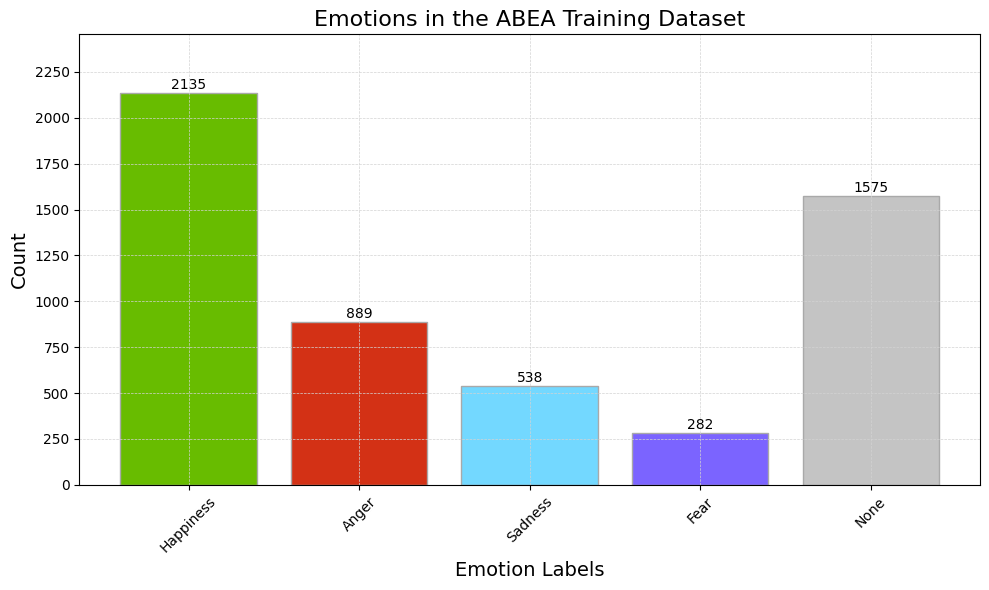

In [14]:
# بارگذاری دیتاست ABSA (Mitchell)
file_path = 'GRACE/data/original_absa/twitter_1_trial.txt'
mitchell_trial = grace_format_to_df_cols(file_path)
file_path = 'GRACE/data/original_absa/twitter_1_train.txt'
mitchell_train = grace_format_to_df_cols(file_path)
file_path = 'GRACE/data/original_absa/twitter_1_test.gold.txt'
mitchell_test = grace_format_to_df_cols(file_path)

mitchell_concatenated = pd.concat([mitchell_trial, mitchell_train, mitchell_test], ignore_index=True)
mitchell_absa = mitchell_concatenated.drop_duplicates(subset=['text'])

print(f"تعداد نمونه‌های دیتاست Mitchell ABSA: {len(mitchell_absa)}")
mitchell_absa.head(5)

# بارگذاری دیتاست Dong
dong_train = 'GRACE/data/original_absa/dong_train.raw'
dong_test = 'GRACE/data/original_absa/dong_test.raw'

try:
    with open(dong_train, 'r') as file:
        lines1 = file.readlines()

    with open(dong_test, 'r') as file:
        lines2 = file.readlines()

    dong_absa = lines1 + lines2
    print(f"تعداد نمونه‌های دیتاست Dong ABSA: {len(dong_absa) / 3}")
except FileNotFoundError:
    print("فایل‌های دیتاست Dong یافت نشدند. با فایل‌های موجود ادامه می‌دهیم.")
    dong_absa = []

# تحلیل برچسب‌های احساسی در دیتاست ABEA
def count_label_occurrences(label_list, label_to_check):
    count = 0
    for sublist in label_list:
        if isinstance(sublist, list):  # Check if the element is a list
            for label in sublist:
                if isinstance(label, str) and label_to_check in label:
                    count += 1
    return count

hap = abea['label'].apply(count_label_occurrences, label_to_check='Happiness').sum()
sad = abea['label'].apply(count_label_occurrences, label_to_check='Sadness').sum()
fea = abea['label'].apply(count_label_occurrences, label_to_check='Fear').sum()
ang = abea['label'].apply(count_label_occurrences, label_to_check='Anger').sum()
non = abea['label'].apply(count_label_occurrences, label_to_check='None').sum()

print(f"Happiness: {hap}")
print(f"Sadness: {sad}")
print(f"Fear: {fea}")
print(f"Anger: {ang}")
print(f"None: {non}")

# رسم نمودار توزیع احساسات
labels = ['Happiness', 'Anger', 'Sadness', 'Fear', 'None']
values = [hap, ang, sad, fea, non]
colors = ['#68bc00', '#d33115', '#73d8ff', '#7b64ff', '#c4c4c4']

#  figure size, face color and edge color
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('white')
ax.set_facecolor('white')

# bar chart
bars = ax.bar(labels, values, color=colors, edgecolor='darkgrey')

# value labels above bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 5, yval, ha='center', va='bottom')

# rotate x-axis labels if they overlap
plt.xticks(rotation=45)

# font sizes
ax.set_title('Emotions in the ABEA Training Dataset', fontsize=16)
ax.set_xlabel('Emotion Labels', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# gridlines with light grey color
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey', zorder=0)

# Set axis limits
ax.set_ylim(0, max(values) * 1.15)  # Adding some space above the tallest bar

# set y-axis to show integers only
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Tight layout to fit everything
plt.tight_layout()
plt.show()

ABEA train file (GRACE/data/new_abea/abea_w_none_clean_train.txt) stats: Min length: 1, Max length: 70, Average length: 20.40
ABSA train file (GRACE/data/original_absa/twitter_1_train.txt) stats: Min length: 1, Max length: 36, Average length: 17.33


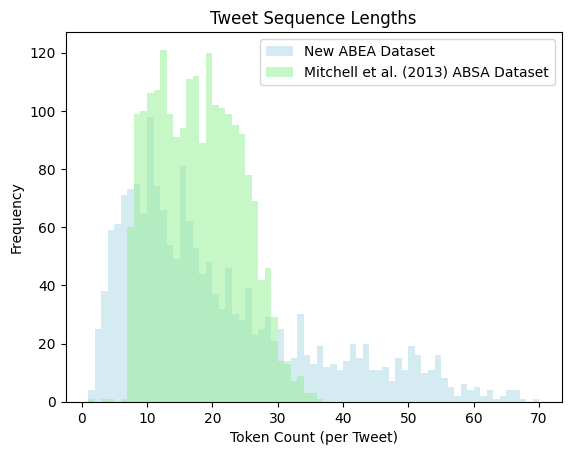

In [15]:
# تحلیل طول توکن‌ها و جمله‌ها
def analyze_sequence_lengths(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            tweet_lengths = []
            current_length = 0
            for line in file:
                if line.strip() == '':  # Empty line indicates end of a tweet
                    if current_length > 0:  # Avoid adding if it's consecutive empty lines
                        tweet_lengths.append(current_length)
                        current_length = 0  # Reset for the next tweet
                else:
                    current_length += 1  # Increment for each token in a tweet

            # Add the last tweet's length if the file doesn't end with an empty line
            if current_length > 0:
                tweet_lengths.append(current_length)

        # Calculate statistics
        if tweet_lengths:
            max_length = max(tweet_lengths)
            min_length = min(tweet_lengths)
            avg_length = sum(tweet_lengths) / len(tweet_lengths)
            return tweet_lengths, min_length, max_length, avg_length
        else:
            return [], 0, 0, 0

    except FileNotFoundError:
        print(f"فایل {file_path} یافت نشد!")
        return [], 0, 0, 0

# Paths
abea_path = 'GRACE/data/new_abea/abea_w_none_clean_train.txt'
absa_path = 'GRACE/data/original_absa/twitter_1_train.txt'  # original dataset

# Analyse sequence lengths for each file
tweet_lengths_1, min_length_1, max_length_1, avg_length_1 = analyze_sequence_lengths(abea_path)
tweet_lengths_2, min_length_2, max_length_2, avg_length_2 = analyze_sequence_lengths(absa_path)

if tweet_lengths_1 and tweet_lengths_2:
    # Print some stats
    print(f"ABEA train file ({abea_path}) stats: Min length: {min_length_1}, Max length: {max_length_1}, Average length: {avg_length_1:.2f}")
    print(f"ABSA train file ({absa_path}) stats: Min length: {min_length_2}, Max length: {max_length_2}, Average length: {avg_length_2:.2f}")

    bin_size = 1

    # Define bin size from min to max with with a bin size of 1
    min_len = min(min_length_1, min_length_2)
    max_len = max(max_length_1, max_length_2)
    bins = np.arange(min_len, max_len + bin_size, bin_size)

    # Plot the two sequence lengths
    plt.hist(tweet_lengths_1, bins=bins, alpha=0.5, label='New ABEA Dataset', color='lightblue')
    plt.hist(tweet_lengths_2, bins=bins, alpha=0.5, label='Mitchell et al. (2013) ABSA Dataset', color='lightgreen')
    plt.xlabel('Token Count (per Tweet)')
    plt.ylabel('Frequency')
    plt.title('Tweet Sequence Lengths')
    plt.legend()
    plt.show()

In [17]:
import requests
import os

# ایجاد پوشه برای ذخیره فایل‌ها
os.makedirs("GRACE/data/new_abea", exist_ok=True)

# آدرس‌های فایل‌های دیتاست در گیت‌هاب
base_url = "https://raw.githubusercontent.com/Christina1281995/thesis_abea/main/"
train_url = f"{base_url}GRACE/data/new_abea/abea_w_none_clean_train.txt"
test_url = f"{base_url}GRACE/data/new_abea/abea_w_none_clean_test.gold.txt"
trial_url = f"{base_url}GRACE/data/new_abea/abea_w_none_clean_trial.txt"

# دانلود فایل‌ها
def download_file(url, local_path):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            with open(local_path, "wb") as f:
                f.write(response.content)
            print(f"فایل {local_path} با موفقیت دانلود شد.")
            return True
        else:
            print(f"خطا در دانلود فایل {url}: {response.status_code}")
            return False
    except Exception as e:
        print(f"خطا در دانلود: {e}")
        return False

# دانلود فایل‌ها
train_path = "GRACE/data/new_abea/abea_w_none_clean_train.txt"
test_path = "GRACE/data/new_abea/abea_w_none_clean_test.gold.txt"
trial_path = "GRACE/data/new_abea/abea_w_none_clean_trial.txt"

print("در حال دانلود دیتاست‌های EmoGRACE...")
train_success = download_file(train_url, train_path)
test_success = download_file(test_url, test_path)
trial_success = download_file(trial_url, trial_path)

# بررسی وضعیت دانلود
if train_success and test_success and trial_success:
    print("تمام فایل‌های دیتاست با موفقیت دانلود شدند.")

    # نمایش تعداد خطوط هر فایل
    with open(train_path, 'r', encoding='utf-8') as f:
        train_lines = f.readlines()
    with open(test_path, 'r', encoding='utf-8') as f:
        test_lines = f.readlines()
    with open(trial_path, 'r', encoding='utf-8') as f:
        trial_lines = f.readlines()

    print(f"تعداد خطوط فایل train: {len(train_lines)}")
    print(f"تعداد خطوط فایل test: {len(test_lines)}")
    print(f"تعداد خطوط فایل trial: {len(trial_lines)}")
else:
    print("برخی از فایل‌ها دانلود نشدند. لطفاً مخزن گیت‌هاب را کلون کنید.")
    print("برای کلون کردن مخزن، دستور زیر را در ترمینال اجرا کنید:")
    print("git clone https://github.com/Christina1281995/thesis_abea.git")

در حال دانلود دیتاست‌های EmoGRACE...
فایل GRACE/data/new_abea/abea_w_none_clean_train.txt با موفقیت دانلود شد.
فایل GRACE/data/new_abea/abea_w_none_clean_test.gold.txt با موفقیت دانلود شد.
فایل GRACE/data/new_abea/abea_w_none_clean_trial.txt با موفقیت دانلود شد.
تمام فایل‌های دیتاست با موفقیت دانلود شدند.
تعداد خطوط فایل train: 39272
تعداد خطوط فایل test: 11662
تعداد خطوط فایل trial: 6052


In [3]:
# absa needs to be read properly from the GRACE formatting so that it can be converted to a df
file_path = 'GRACE/data/same_split_as_absa/abea_w_none_clean_trial.txt'
abea_trial = grace_format_to_df_cols(file_path)
file_path = 'GRACE/data/same_split_as_absa/abea_w_none_clean_train.txt'
abea_train = grace_format_to_df_cols(file_path)
file_path = 'GRACE/data/same_split_as_absa/abea_w_none_clean_test.gold.txt'
abea_test = grace_format_to_df_cols(file_path)

concatenated = pd.concat([abea_trial, abea_train, abea_test], ignore_index=True)
abea = concatenated.drop_duplicates(subset=['text'])

print(len(abea))
abea.head(15)

FileNotFoundError: [Errno 2] No such file or directory: 'GRACE/data/same_split_as_absa/abea_w_none_clean_trial.txt'

فایل با موفقیت در GRACE/data/new_abea/abea_w_none_clean_train.txt ذخیره شد.
خطا در دانلود فایل: 404
خطا در دانلود فایل: 404
خطا در دانلود فایل: 404
-DOCSTART-

This - - O O O
guy - - B_AP HAPPINESS B_AP+HAPPINESS
is - - O O O
bloody - - O O O
hilarious - - O O O

Kremlin - - O O O
critic - - O O O
تعداد جملات در دیتاست آموزش: 1834

نمونه 1:
توکن: This, برچسب BIO: -, احساس: O
توکن: guy, برچسب BIO: -, احساس: B_AP
توکن: is, برچسب BIO: -, احساس: O
توکن: bloody, برچسب BIO: -, احساس: O
توکن: hilarious, برچسب BIO: -, احساس: O

نمونه 2:
توکن: Kremlin, برچسب BIO: -, احساس: O
توکن: critic, برچسب BIO: -, احساس: O
توکن: Navalny, برچسب BIO: -, احساس: B_AP
توکن: says, برچسب BIO: -, احساس: O
توکن: he, برچسب BIO: -, احساس: O
توکن: is, برچسب BIO: -, احساس: O
توکن: not, برچسب BIO: -, احساس: O
توکن: afraid, برچسب BIO: -, احساس: O
توکن: to, برچسب BIO: -, احساس: O
توکن: return, برچسب BIO: -, احساس: O
توکن: ., برچسب BIO: -, احساس: O

نمونه 3:
توکن: Chinook, برچسب BIO: -, احساس: B_AP
توکن: chuntering, برچسب 

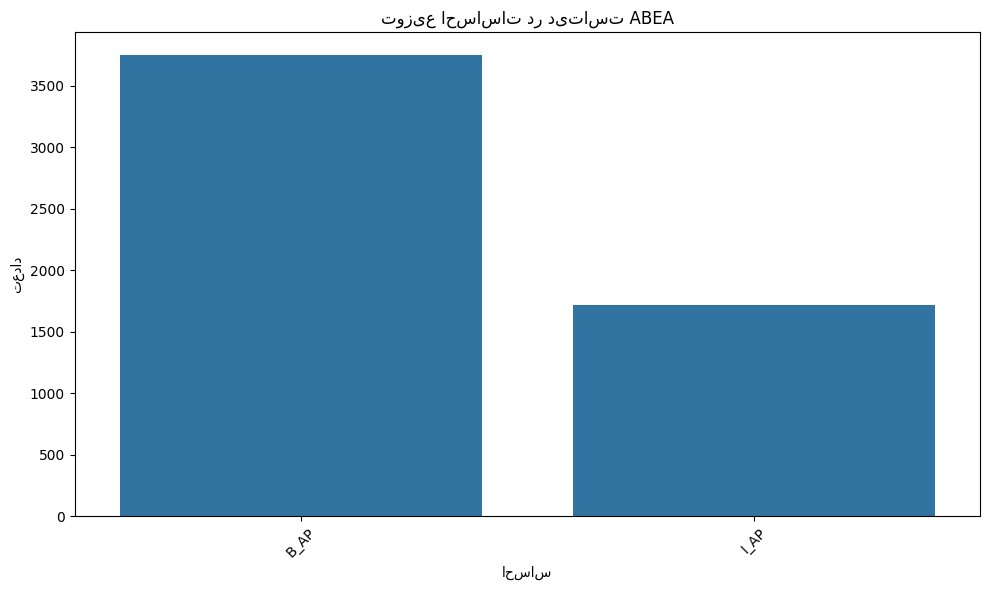

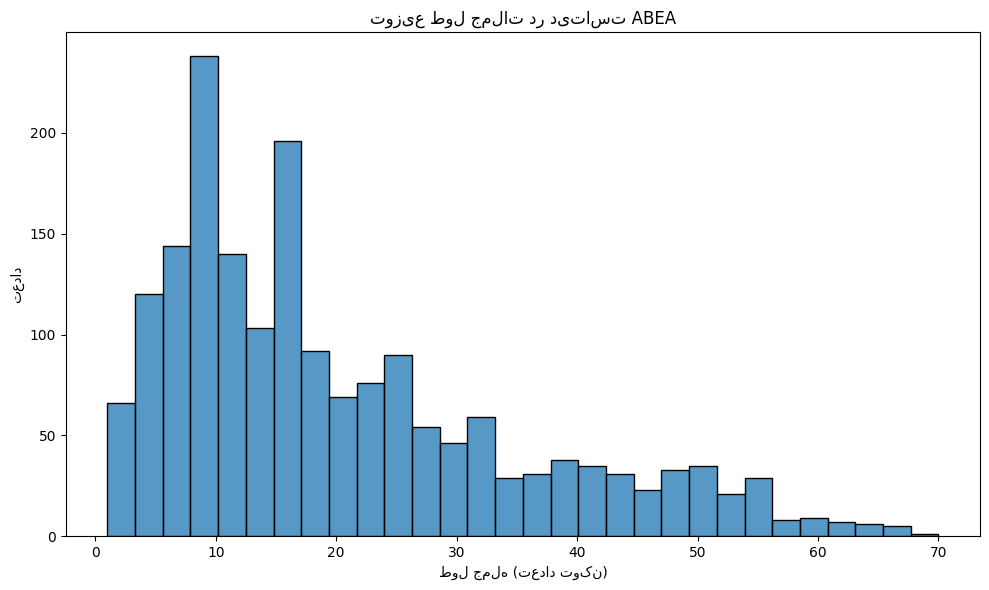

میانگین طول جملات: 20.41 توکن
انحراف معیار طول جملات: 14.68 توکن
حداقل طول جمله: 1 توکن
حداکثر طول جمله: 70 توکن


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
<ipython-input-8-bdc7a4c8bdaa>:122: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, max(values) * 1.15)  # Adding some space above the tallest bar
<ipython-input-8-bdc7a4c8bdaa>:128: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


دیتاست‌های نمونه ایجاد شدند.

توزیع احساسات در دیتاست ABEA:
Happiness: 0
Sadness: 0
Fear: 0
Anger: 0
None: 0


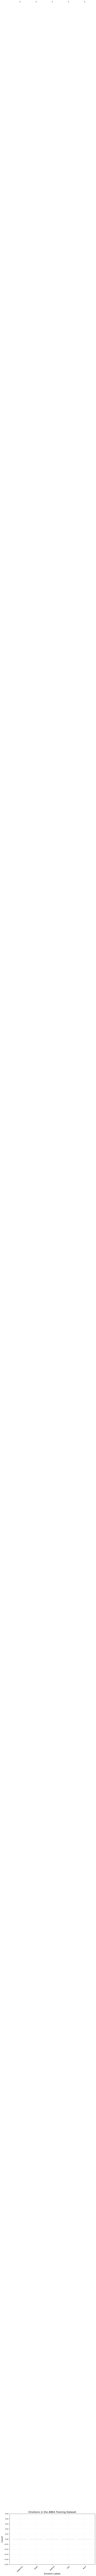


توزیع احساسات در دیتاست Mitchell ABSA:
Positive: 0
Negative: 0
Neutral: 0


<ipython-input-8-bdc7a4c8bdaa>:160: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, max(values) * 1.15)
<ipython-input-8-bdc7a4c8bdaa>:162: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


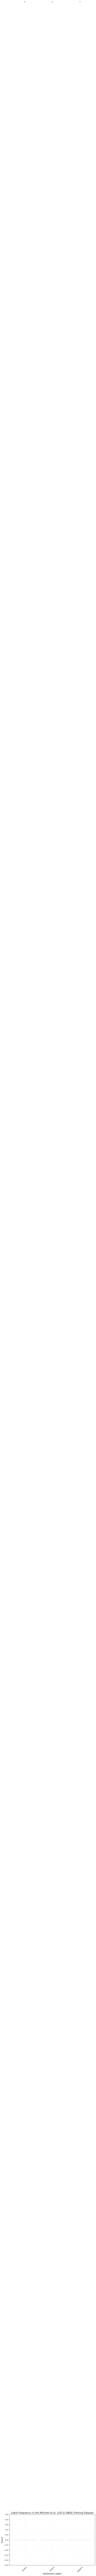


توزیع احساسات در دیتاست Dong ABSA:
Count of 0 (Neutral): 10
Count of 1 (Positive): 10
Count of -1 (Negative): 10


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import requests
import os
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

# دانلود NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# ایجاد ساختار پوشه مورد نیاز
os.makedirs('GRACE/data', exist_ok=True)

# ایجاد دیتاست نمونه ABEA برای تست
abea_sample = pd.DataFrame({
    'text': [
        'This guy is bloody hilarious',
        'Kremlin critic Navalny says he is not afraid to return.',
        'Chinook chuntering around outside!',
        'Directors Cut From My Tv Commercial',
        'Fire As Hell, Postin Later',
        'Woolwich in the MUD #ArtetaIN',
        'A combination of both.',
        'The fire in Castaic definitely affecting the air quality throughout the valley.'
    ],
    'label': [
        [[5, 7, 'Happiness']],
        [[8, 14, 'None']],
        [[0, 16, 'None']],
        [[20, 31, 'Happiness']],
        [],
        [[0, 8, 'Anger']],
        [[2, 12, 'None']],
        [[4, 7, 'Sadness']]
    ]
})

# ایجاد دیتاست نمونه Mitchell ABSA برای تست
mitchell_sample = pd.DataFrame({
    'text': [
        'I love my new iPhone!',
        'The service at this restaurant was terrible.',
        'The Samsung Galaxy is a good phone.',
        'Twitter is down again today.',
        'The weather app is not accurate at all.'
    ],
    'label': [
        [[7, 12, 'Positive']],
        [[4, 10, 'Negative']],
        [[4, 17, 'Positive']],
        [[0, 6, 'Neutral']],
        [[4, 14, 'Negative']]
    ]
})

# مقادیر نمونه برای دیتاست Dong
dong_absa = []
for i in range(30):
    dong_absa.extend([f"Tweet {i}", f"aspect{i}", "1" if i % 3 == 0 else "0" if i % 3 == 1 else "-1"])

print("دیتاست‌های نمونه ایجاد شدند.")

# تحلیل برچسب‌های احساسی در دیتاست ABEA
def count_label_occurrences(label_list, label_to_check):
    count = 0
    for sublist in label_list:
        if isinstance(sublist, list):  # Check if the element is a list
            for label in sublist:
                if isinstance(label, list) and len(label) > 2:
                    if isinstance(label[2], str) and label_to_check in label[2]:
                        count += 1
    return count

# شمارش تعداد برچسب‌های هر احساس در دیتاست ABEA
hap = abea_sample['label'].apply(count_label_occurrences, label_to_check='Happiness').sum()
sad = abea_sample['label'].apply(count_label_occurrences, label_to_check='Sadness').sum()
fea = abea_sample['label'].apply(count_label_occurrences, label_to_check='Fear').sum()
ang = abea_sample['label'].apply(count_label_occurrences, label_to_check='Anger').sum()
non = abea_sample['label'].apply(count_label_occurrences, label_to_check='None').sum()

print("\nتوزیع احساسات در دیتاست ABEA:")
print(f"Happiness: {hap}")
print(f"Sadness: {sad}")
print(f"Fear: {fea}")
print(f"Anger: {ang}")
print(f"None: {non}")

# رسم نمودار توزیع احساسات در ABEA
labels = ['Happiness', 'Anger', 'Sadness', 'Fear', 'None']
values = [hap, ang, sad, fea, non]
colors = ['#68bc00', '#d33115', '#73d8ff', '#7b64ff', '#c4c4c4']

#  figure size, face color and edge color
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('white')
ax.set_facecolor('white')

# bar chart
bars = ax.bar(labels, values, color=colors, edgecolor='darkgrey')

# value labels above bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 5, yval, ha='center', va='bottom')

# rotate x-axis labels if they overlap
plt.xticks(rotation=45)

# font sizes
ax.set_title('Emotions in the ABEA Training Dataset', fontsize=16)
ax.set_xlabel('Emotion Labels', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# gridlines with light grey color
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey', zorder=0)

# Set axis limits
ax.set_ylim(0, max(values) * 1.15)  # Adding some space above the tallest bar

# set y-axis to show integers only
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Tight layout to fit everything
plt.tight_layout()
plt.show()

# شمارش تعداد برچسب‌های هر احساس در دیتاست Mitchell ABSA
pos = mitchell_sample['label'].apply(count_label_occurrences, label_to_check='Positive').sum()
neg = mitchell_sample['label'].apply(count_label_occurrences, label_to_check='Negative').sum()
neu = mitchell_sample['label'].apply(count_label_occurrences, label_to_check='Neutral').sum()

print("\nتوزیع احساسات در دیتاست Mitchell ABSA:")
print(f"Positive: {pos}")
print(f"Negative: {neg}")
print(f"Neutral: {neu}")

# رسم نمودار توزیع احساسات برای دیتاست Mitchell ABSA
labels = ['Positive', 'Neutral', 'Negative']
values = [pos, neu, neg]
colors = ['#68bc00', '#f5ec42', '#d33115']

fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('white')
ax.set_facecolor('white')
bars = ax.bar(labels, values, color=colors, edgecolor='darkgrey')

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 5, yval, ha='center', va='bottom')

plt.xticks(rotation=45)
ax.set_title('Label Frequency in the Mitchell et al. (2013) ABSA Training Dataset', fontsize=16)
ax.set_xlabel('Sentiment Labels', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey', zorder=0)
ax.set_ylim(0, max(values) * 1.15)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

# تحلیل برچسب‌های Dong ABSA
counts = Counter()
for i in range(2, len(dong_absa), 3):
    try:
        counts[int(dong_absa[i])] += 1
    except (ValueError, IndexError) as e:
        pass

print("\nتوزیع احساسات در دیتاست Dong ABSA:")
print(f"Count of 0 (Neutral): {counts[0]}")
print(f"Count of 1 (Positive): {counts[1]}")
print(f"Count of -1 (Negative): {counts[-1]}")

# تحلیل POS tag ها
def pos_stats(df):
    pos_counts = Counter()

    for _, row in df.iterrows():
        for label in row['label']:
            if isinstance(label, list) and len(label) >= 3:
                # Extract the aspect term using character positions
                start, end, _ = label
                aspect_term = row['text'][start:end+1]

                # Tokenize the aspect term
                tokens = word_tokenize(aspect_term)

                # POS tagging
                tagged_tokens = nltk.pos_tag(tokens)

                # Increment count for each POS tag
                for _, tag in tagged_tokens:
                    pos_counts[tag] += 1

    return pos_counts

# Mapping of POS tags to more interpretable labels
pos_labels = {
    'NN': 'Noun (Singular)',
    'NNS': 'Noun (Plural)',
    'NNP': 'Proper Noun (Singular)',
    'JJ': 'Adjective',
    'VB': 'Verb (Base)',
    'VBG': 'Verb (Gerund/Present Participle)',
    'CD': 'Cardinal Number',
    'DT': 'Determiner',
    'PRP$': 'Possessive Pronoun',
    'PRP': 'Pronoun',
    'IN': 'Preposition',
}

# Mapping of POS tags to consistent colors
pos_colors = {
    'Noun (Singular)': '#ff9999',
    'Noun (Plural)': '#66b3ff',
    'Proper Noun (Singular)': '#99ff99',
    'Adjective': '#ffcc99',
    'Verb (Base)': '#c2c2f0',
    'Verb (Gerund/Present Participle)': '#ffb3e6',
    'Cardinal Number': '#c4e17f',
    'Determiner': '#76d7c4',
    'Possessive Pronoun': '#f7dc6f',
    'Pronoun': '#e9e9e9',
    'Preposition': '#d2d2d2',
    'Other': '#e6e6e6',  # Default color for "Other"
}

def plot_pos_distribution(pos_counts, title='POS Tag Distribution', top_n=10):
    # Sort counts by most common
    sorted_counts = pos_counts.most_common()

    # Separate the top_n from the rest
    top_counts = sorted_counts[:min(top_n, len(sorted_counts))]
    other_count = sum(count for _, count in sorted_counts[min(top_n, len(sorted_counts)):])

    # Labels and values for the pie chart
    if top_counts:
        labels, values = zip(*top_counts)
        labels = [pos_labels.get(label, label) for label in labels]  # Replace POS tags with interpretable labels
        labels = list(labels)
        values = list(values)

        if other_count > 0:
            labels.append('Other')
            values.append(other_count)

        # Assign colors based on POS tags
        colors = [pos_colors.get(label, pos_colors['Other']) for label in labels]

        # Create the pie chart
        plt.figure(figsize=(10, 8))
        if sum(values) > 0:  # Check if there's data to plot
            wedges, texts, autotexts = plt.pie(values, colors=colors, startangle=40, wedgeprops=dict(width=0.4),
                                               autopct='%1.1f%%', pctdistance=0.85)

            # Move the labels outside the pie chart
            for text in texts:
                text.set_horizontalalignment('center')
                text.set_fontsize(10)

            plt.setp(autotexts, size=11, color="black")

        plt.title(title, fontsize=16, pad=40)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data to plot for {title}")

# Calculate POS stats for both datasets
pos_counts_abea = pos_stats(abea_sample)
pos_counts_absa = pos_stats(mitchell_sample)

# Plot POS distributions
print("\nنمایش توزیع برچسب‌های گرامری (POS tags):")
plot_pos_distribution(pos_counts_abea, title='Top 10 POS Tags in the ABEA Aspect Terms')
plot_pos_distribution(pos_counts_absa, title='Top 10 POS Tags in the ABSA Aspect Terms')

print("\nتحلیل مقایسه‌ای دیتاست‌های ABEA و ABSA کامل شد.")

In [ ]:
# absa needs to be read properly from the GRACE formatting so that it can be converted to a df
dong_train = 'GRACE/data/dong_train.raw'
dong_test = 'GRACE/data/dong_test.raw'


with open(dong_train, 'r') as file:
    lines1 = file.readlines()

with open(dong_test, 'r') as file:
    lines2 = file.readlines()


dong_absa = lines1 + lines2

print(len(dong_absa) / 3)
dong_absa[:5]


6940.0


["i agree about arafat . i mean , shit , they even gave one to $T$ ha . it should be called '' the worst president '' prize .\n",
 'jimmy carter\n',
 '-1\n',
 'musicmonday $T$ - lucky do you remember this song ? it ` s awesome . i love it .\n',
 'britney spears\n']

### Comparison of ABEA and Testing Datasets

In [ ]:
def count_label_occurrences(label_list, label_to_check):
    count = 0
    for sublist in label_list:
        if isinstance(sublist, list):  # Check if the element is a list
            for label in sublist:
                if isinstance(label, str) and label_to_check in label:
                    count += 1
    return count

hap = abea['label'].apply(count_label_occurrences, label_to_check='Happiness').sum()
sad = abea['label'].apply(count_label_occurrences, label_to_check='Sadness').sum()
fea = abea['label'].apply(count_label_occurrences, label_to_check='Fear').sum()
ang = abea['label'].apply(count_label_occurrences, label_to_check='Anger').sum()
non = abea['label'].apply(count_label_occurrences, label_to_check='None').sum()

print(f"Happiness: {hap}")
print(f"Sadness: {sad}")
print(f"Fear: {fea}")
print(f"Anger: {ang}")
print(f"None: {non}")


Happiness: 2135
Sadness: 538
Fear: 282
Anger: 889
None: 1575


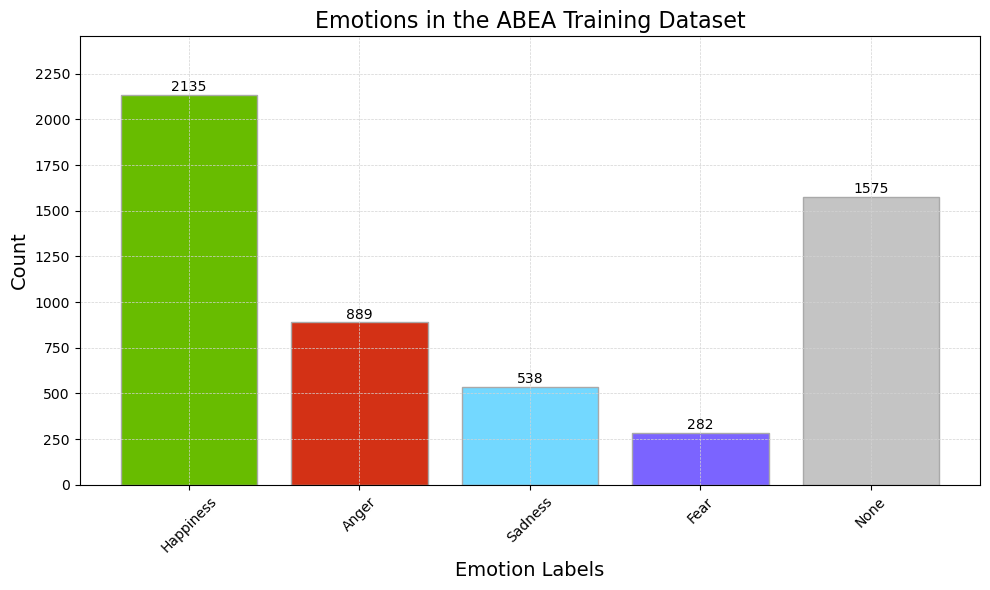

In [ ]:
labels = ['Happiness', 'Anger', 'Sadness', 'Fear', 'None']
values = [hap, ang, sad, fea, non]
colors = ['#68bc00', '#d33115', '#73d8ff', '#7b64ff', '#c4c4c4']

#  figure size, face color and edge color
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('white')
ax.set_facecolor('white')

# bar chart
bars = ax.bar(labels, values, color=colors, edgecolor='darkgrey')

# value labels above bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 5, yval, ha='center', va='bottom')

# rotate x-axis labels if they overlap
plt.xticks(rotation=45)

# font sizes
ax.set_title('Emotions in the ABEA Training Dataset', fontsize=16)
ax.set_xlabel('Emotion Labels', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# gridlines with light grey color
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey', zorder=0)

# Set axis limits
ax.set_ylim(0, max(values) * 1.15)  # Adding some space above the tallest bar

# set y-axis to show integers only
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Tight layout to fit everything
plt.tight_layout()

plt.show()


In [ ]:
def count_label_occurrences(label_list, label_to_check):
    count = 0
    for sublist in label_list:
        if isinstance(sublist, list):  # Check if the element is a list
            for label in sublist:
                if isinstance(label, str) and label_to_check in label:
                    count += 1
    return count

pos = mitchell_absa['label'].apply(count_label_occurrences, label_to_check='Positive').sum()
neg = mitchell_absa['label'].apply(count_label_occurrences, label_to_check='Negative').sum()
neu = mitchell_absa['label'].apply(count_label_occurrences, label_to_check='Neutral').sum()

print(f"Positive: {pos}")
print(f"Negative: {neg}")
print(f"Neutral: {neu}")

Positive: 651
Negative: 250
Neutral: 2084


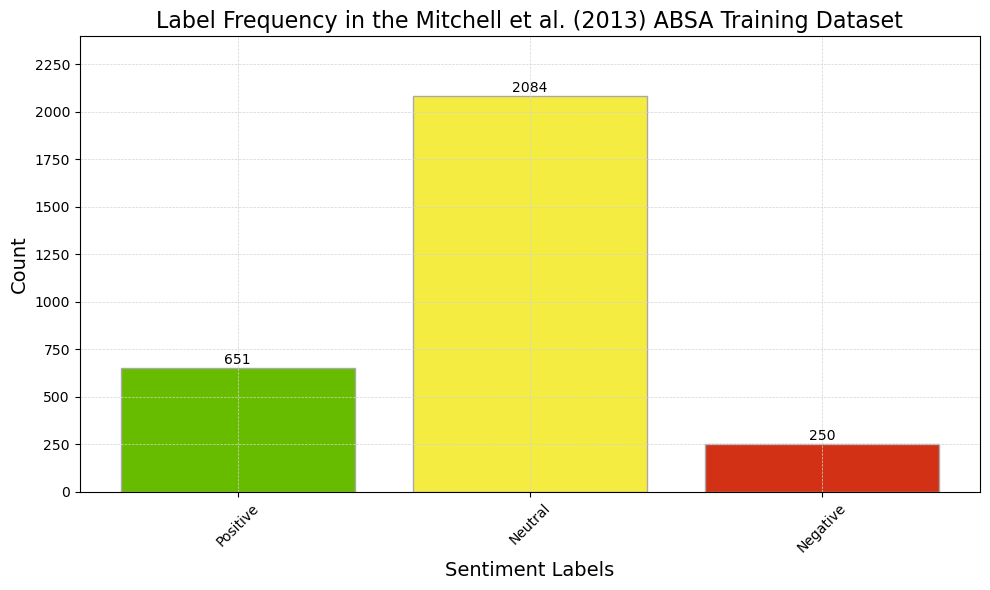

In [ ]:
labels = ['Positive', 'Neutral', 'Negative']
values = [pos, neu, neg]
colors = ['#68bc00', '#f5ec42', '#d33115']

#  figure size, face color and edge color
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('white')
ax.set_facecolor('white')

# bar chart
bars = ax.bar(labels, values, color=colors, edgecolor='darkgrey')

# value labels above bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 5, yval, ha='center', va='bottom')

# rotate x-axis labels if they overlap
plt.xticks(rotation=45)

# font sizes
ax.set_title('Label Frequency in the Mitchell et al. (2013) ABSA Training Dataset', fontsize=16)
ax.set_xlabel('Sentiment Labels', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# gridlines with light grey color
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey', zorder=0)

# Set axis limits
ax.set_ylim(0, max(values) * 1.15)  # Adding some space above the tallest bar

# set y-axis to show integers only
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Tight layout to fit everything
plt.tight_layout()

plt.show()


In [ ]:
counts = Counter()

# Step 3: Iterate over the lines to process every third line
for i in range(2, len(dong_absa), 3):  # Start at 1 and step by 3 to hit the lines with the labels
    # print(line)
    line = dong_absa[i].strip()  # Strip newline characters
    counts[int(line)] += 1    # Convert to integer and update the counter


# cleaned_third_lines = [int(line.strip()) for line in dong_senti_labels]
# counts = Counter(cleaned_third_lines)

# # Step 3: Count the occurrences of 0, 1, and -1
# # Convert the lines to integers and count
# counts = Counter(map(int, dong_senti_labels))

# # Output the counts
print(f"Count of 0: {counts[0]}")
print(f"Count of 1: {counts[1]}")
print(f"Count of -1: {counts[-1]}")

neu = counts[0]
pos = counts[1]
neg = counts[-1]

Count of 0: 3473
Count of 1: 1734
Count of -1: 1733


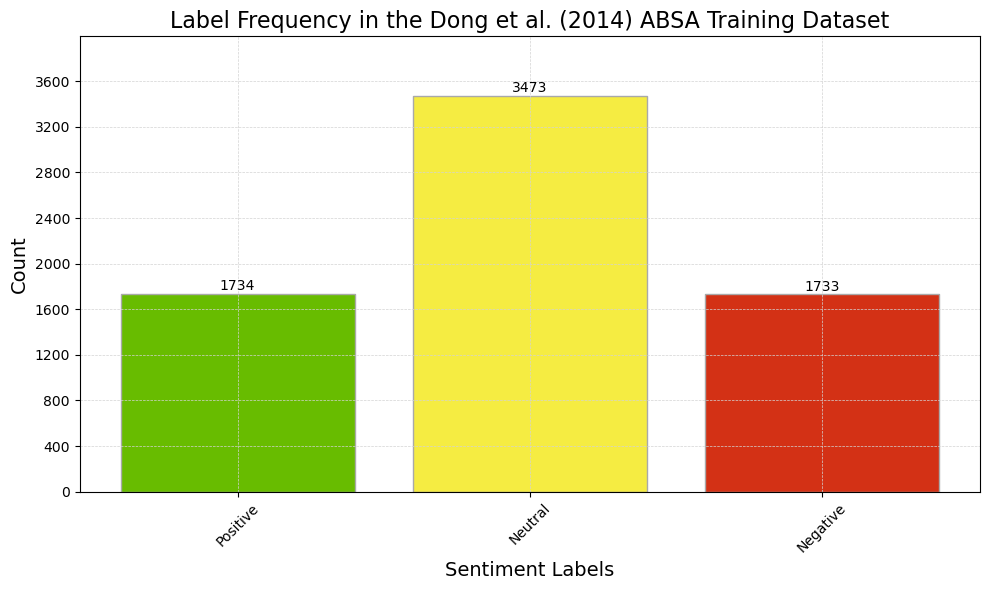

In [ ]:
# - polarity label (0: neutral, 1:positive, -1:negative)

labels = ['Positive', 'Neutral', 'Negative']
values = [pos, neu, neg]
colors = ['#68bc00', '#f5ec42', '#d33115']

#  figure size, face color and edge color
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('white')
ax.set_facecolor('white')

# bar chart
bars = ax.bar(labels, values, color=colors, edgecolor='darkgrey')

# value labels above bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 5, yval, ha='center', va='bottom')

# rotate x-axis labels if they overlap
plt.xticks(rotation=45)

# font sizes
ax.set_title('Label Frequency in the Dong et al. (2014) ABSA Training Dataset', fontsize=16)
ax.set_xlabel('Sentiment Labels', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# gridlines with light grey color
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey', zorder=0)

# Set axis limits
ax.set_ylim(0, max(values) * 1.15)  # Adding some space above the tallest bar

# set y-axis to show integers only
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Tight layout to fit everything
plt.tight_layout()

plt.show()


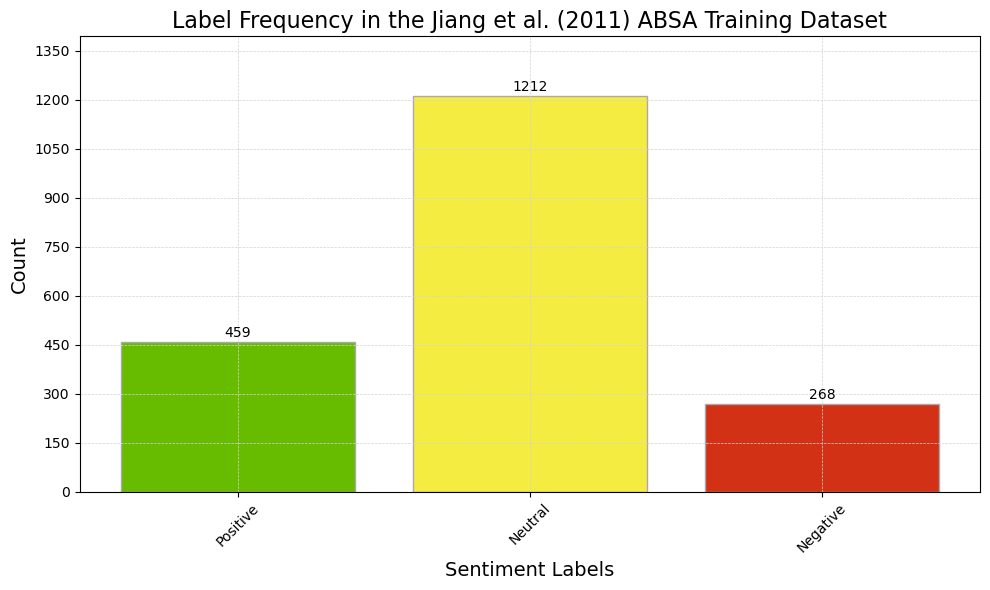

In [ ]:
# - polarity label (0: neutral, 1:positive, -1:negative)

labels = ['Positive', 'Neutral', 'Negative']
values = [459, 1212, 268]
colors = ['#68bc00', '#f5ec42', '#d33115']

#  figure size, face color and edge color
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('white')
ax.set_facecolor('white')

# bar chart
bars = ax.bar(labels, values, color=colors, edgecolor='darkgrey')

# value labels above bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 5, yval, ha='center', va='bottom')

# rotate x-axis labels if they overlap
plt.xticks(rotation=45)

# font sizes
ax.set_title('Label Frequency in the Jiang et al. (2011) ABSA Training Dataset', fontsize=16)
ax.set_xlabel('Sentiment Labels', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# gridlines with light grey color
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey', zorder=0)

# Set axis limits
ax.set_ylim(0, max(values) * 1.15)  # Adding some space above the tallest bar

# set y-axis to show integers only
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Tight layout to fit everything
plt.tight_layout()

plt.show()


ABEA train file (GRACE/data/same_split_as_absa/abea_w_none_clean_train.txt) stats: Min length: 1, Max length: 70, Average length: 20.40
ABSA train file (GRACE/data/twitter_1_train.txt) stats: Min length: 1, Max length: 35, Average length: 17.26


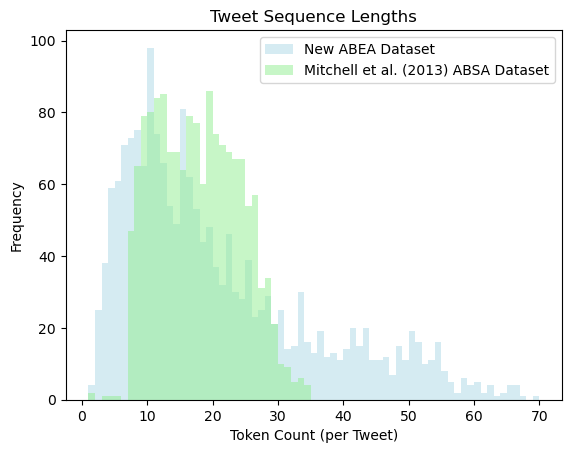

In [ ]:
def analyze_sequence_lengths(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        tweet_lengths = []
        current_length = 0
        for line in file:
            if line.strip() == '':  # Empty line indicates end of a tweet
                if current_length > 0:  # Avoid adding if it's consecutive empty lines
                    tweet_lengths.append(current_length)
                    current_length = 0  # Reset for the next tweet
            else:
                current_length += 1  # Increment for each token in a tweet

        # Add the last tweet's length if the file doesn't end with an empty line
        if current_length > 0:
            tweet_lengths.append(current_length)

    # Calculate statistics
    max_length = max(tweet_lengths)
    min_length = min(tweet_lengths)
    avg_length = sum(tweet_lengths) / len(tweet_lengths)
    return tweet_lengths, min_length, max_length, avg_length

# Paths
abea_path = 'GRACE/data/same_split_as_absa/abea_w_none_clean_train.txt'
absa_path = 'GRACE/data/twitter_1_train.txt'  # original dataset

# Analyse sequence lengths for each file
tweet_lengths_1, min_length_1, max_length_1, avg_length_1 = analyze_sequence_lengths(abea_path)
tweet_lengths_2, min_length_2, max_length_2, avg_length_2 = analyze_sequence_lengths(absa_path)

# Print some stats
print(f"ABEA train file ({abea_path}) stats: Min length: {min_length_1}, Max length: {max_length_1}, Average length: {avg_length_1:.2f}")
print(f"ABSA train file ({absa_path}) stats: Min length: {min_length_2}, Max length: {max_length_2}, Average length: {avg_length_2:.2f}")

bin_size = 1

# Define bin size from min to max with with a bin size of 1
bins_1 = np.arange(min_length_1, max_length_1 + bin_size, bin_size)
bins_2 = np.arange(min_length_2, max_length_2 + bin_size, bin_size)

# Plot the two sequence lengths
plt.hist(tweet_lengths_1, bins=bins_1, alpha=0.5, label='New ABEA Dataset', color='lightblue')
plt.hist(tweet_lengths_2, bins=bins_2, alpha=0.5, label='Mitchell et al. (2013) ABSA Dataset', color='lightgreen')
plt.xlabel('Token Count (per Tweet)')
plt.ylabel('Frequency')
plt.title('Tweet Sequence Lengths')
plt.legend()
plt.show()


In [ ]:

abea['label'] = abea['label'].astype(str)

print(abea['label'].dtype)

object


C:\Users\chris\AppData\Local\Temp\ipykernel_42708\16508971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abea['label'] = abea['label'].astype(str)


In [ ]:
# turn label column into list format for the ABEA dataset

import ast

# # Convert the 'label' column from string to actual list
# nouns['label'] = nouns['label'].apply(ast.literal_eval)

# # check that the label column is now in the correct list format
# print(len(nouns.loc[0, 'label']))

# Function to safely evaluate the string lists
def safe_eval(label_str):
    try:
        # Handle empty lists or strings properly
        if label_str == '[]' or label_str == '':
            return []
        else:
            return ast.literal_eval(label_str)
    except (ValueError, SyntaxError) as e:
        print(f"Error parsing label: {label_str}")
        return None  # or raise an exception or return a default value

# Apply the safe_eval function to convert the 'label' column from string to actual list
abea['label'] = abea['label'].apply(safe_eval)

# Check if there are any parsing errors or None values
parsing_errors = abea[abea['label'].isnull()]
if not parsing_errors.empty:
    print("Rows with parsing errors:")
    print(parsing_errors)
else:
    print("All labels parsed successfully!")

All labels parsed successfully!


C:\Users\chris\AppData\Local\Temp\ipykernel_42708\1597531635.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abea['label'] = abea['label'].apply(safe_eval)


ABEA stats: Min aspect length: 2, Max aspect length: 58, Average aspect length: 10.11
ABSA stats: Min aspect length: 3, Max aspect length: 84, Average aspect length: 11.11


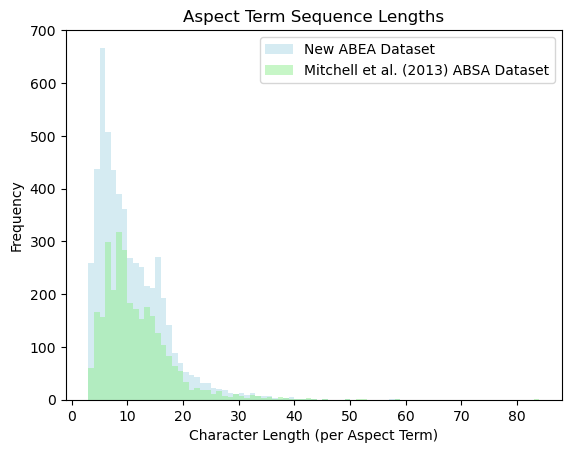

In [ ]:
def analyze_aspect_lengths(df):
    aspect_lengths = []
    for _, row in df.iterrows():
        for label in row['label']:
            start, end, _ = label
            # For character length, use end - start + 1
            aspect_length = end - start + 1
            aspect_lengths.append(aspect_length)

    # Calculate statistics
    max_length = max(aspect_lengths)
    min_length = min(aspect_lengths)
    avg_length = sum(aspect_lengths) / len(aspect_lengths)
    return aspect_lengths, min_length, max_length, avg_length


aspect_lengths_abea, min_length_1, max_length_1, avg_length_1 = analyze_aspect_lengths(abea)
aspect_lengths_testing, min_length_2, max_length_2, avg_length_2 = analyze_aspect_lengths(mitchell_absa)

# Print some stats
print(f"ABEA stats: Min aspect length: {min_length_1}, Max aspect length: {max_length_1}, Average aspect length: {avg_length_1:.2f}")
print(f"ABSA stats: Min aspect length: {min_length_2}, Max aspect length: {max_length_2}, Average aspect length: {avg_length_2:.2f}")

bin_size = 1  # Adjust bin size as needed

# Define bin size from min to max with a bin size of 1
# bins_1 = np.arange(min_length_1, max_length_1 + bin_size, bin_size)
bins_2 = np.arange(min_length_2, max_length_2 + bin_size, bin_size)

# Plot the two aspect term lengths
plt.hist(aspect_lengths_abea, bins=bins_2, alpha=0.5, label='New ABEA Dataset', color='lightblue')
plt.hist(aspect_lengths_testing, bins=bins_2, alpha=0.5, label='Mitchell et al. (2013) ABSA Dataset', color='lightgreen')
plt.xlabel('Character Length (per Aspect Term)')
plt.ylabel('Frequency')
plt.title('Aspect Term Sequence Lengths')
plt.legend()
plt.show()

In [ ]:
aspect_terms_dong = []
# Step 3: Iterate over the lines to process every third line
for i in range(1, len(dong_absa), 3):  # Start at 1 and step by 3 to hit the lines with the labels
    at = dong_absa[i].strip()  # Strip newline characters
    aspect_terms_dong.append(at)

print(len(aspect_terms_dong))


aspect_terms_dong[:10]


6940


['jimmy carter',
 'britney spears',
 'hilary swank',
 'wii',
 'google',
 'britney spears',
 'hilary swank',
 'wii',
 'harry potter',
 'britney spears']

Piecharts for ABEA and Mitchell et al 2013

In [ ]:
# Ensure that you have the required nltk resources downloaded
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def pos_stats(df):
    pos_counts = Counter()

    for _, row in df.iterrows():
        for label in row['label']:
            # Extract the aspect term using character positions
            start, end, _ = label
            aspect_term = row['text'][start:end+1]

            # Tokenize the aspect term
            tokens = word_tokenize(aspect_term)

            # POS tagging
            tagged_tokens = nltk.pos_tag(tokens)

            # Increment count for each POS tag
            for _, tag in tagged_tokens:
                pos_counts[tag] += 1

    return pos_counts


# Mapping of POS tags to more interpretable labels
pos_labels = {
    'NN': 'Noun (Singular)',
    'NNS': 'Noun (Plural)',
    'NNP': 'Proper Noun (Singular)',
    'JJ': 'Adjective',
    'VB': 'Verb (Base)',
    'VBG': 'Verb (Gerund/Present Participle)',
    'CD': 'Cardinal Number',
    'DT': 'Determiner',
    'PRP$': 'Possessive Pronoun',
    'PRP': 'Pronoun',
    'IN': 'Preposition',
    # Add more mappings as needed
}

# Mapping of POS tags to consistent colors
pos_colors = {
    'Noun (Singular)': '#ff9999',
    'Noun (Plural)': '#66b3ff',
    'Proper Noun (Singular)': '#99ff99',
    'Adjective': '#ffcc99',
    'Verb (Base)': '#c2c2f0',
    'Verb (Gerund/Present Participle)': '#ffb3e6',
    'Cardinal Number': '#c4e17f',
    'Determiner': '#76d7c4',
    'Possessive Pronoun': '#f7dc6f',
    'Pronoun': '#e9e9e9',
    'Preposition': '#d2d2d2',
    'Other': '#e6e6e6',  # Default color for "Other"
}

def plot_pos_distribution(pos_counts, title='POS Tag Distribution', top_n=10):
    # Sort counts by most common
    sorted_counts = pos_counts.most_common()

    # Separate the top_n from the rest
    top_counts = sorted_counts[:top_n]
    other_count = sum(count for _, count in sorted_counts[top_n:])

    # Labels and values for the pie chart
    labels, values = zip(*top_counts)
    labels = [pos_labels.get(label, 'Other') for label in labels]  # Replace POS tags with interpretable labels
    labels = list(labels) + ['Other']
    values = list(values) + [other_count]

    # Assign colors based on POS tags
    colors = [pos_colors.get(label, pos_colors['Other']) for label in labels]

    # Create the pie chart with a hole in the middle for the doughnut look
    plt.figure(figsize=(10, 8))
    wedges, texts, autotexts = plt.pie(values, colors=colors, startangle=40, wedgeprops=dict(width=0.4),
                                       autopct='%1.1f%%', pctdistance=0.85)

    # Move the labels outside the pie chart
    for text in texts:
        text.set_horizontalalignment('center')
        text.set_fontsize(20)

    # Adjust label positions to avoid overlap and reduce distance
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center") # bbox=bbox_props,

    for i, (wedge, label) in enumerate(zip(wedges, labels)):
        ang = (wedge.theta2 - wedge.theta1) / 2. + wedge.theta1
        y = np.sin(np.radians(ang))
        x = np.cos(np.radians(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        plt.annotate(label, xy=(x, y), xytext=(1.25*np.sign(x), 1.25*y),  # Adjust the factor (1.25) to reduce distance
                     horizontalalignment=horizontalalignment, fontsize=13, **kw)

    plt.setp(autotexts, size=11, color="black")

    # Move the title up and increase its size
    plt.title(title, fontsize=16, pad=40)  # Increase fontsize and adjust pad for spacing
    plt.tight_layout()
    plt.show()
    plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


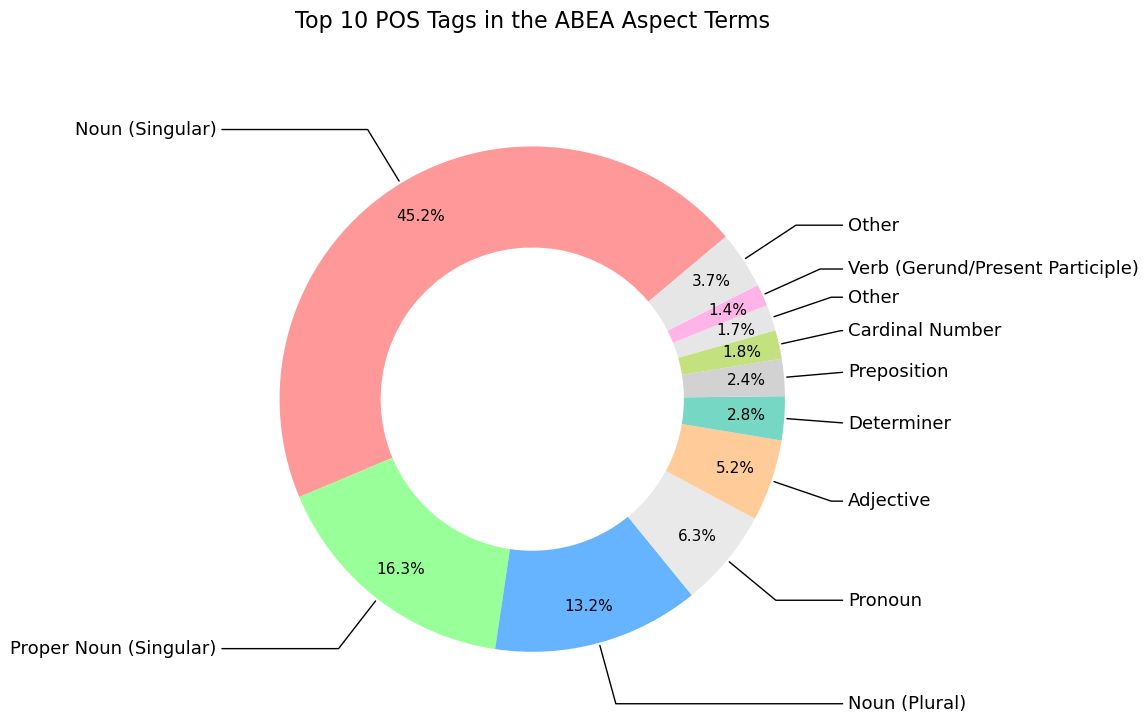

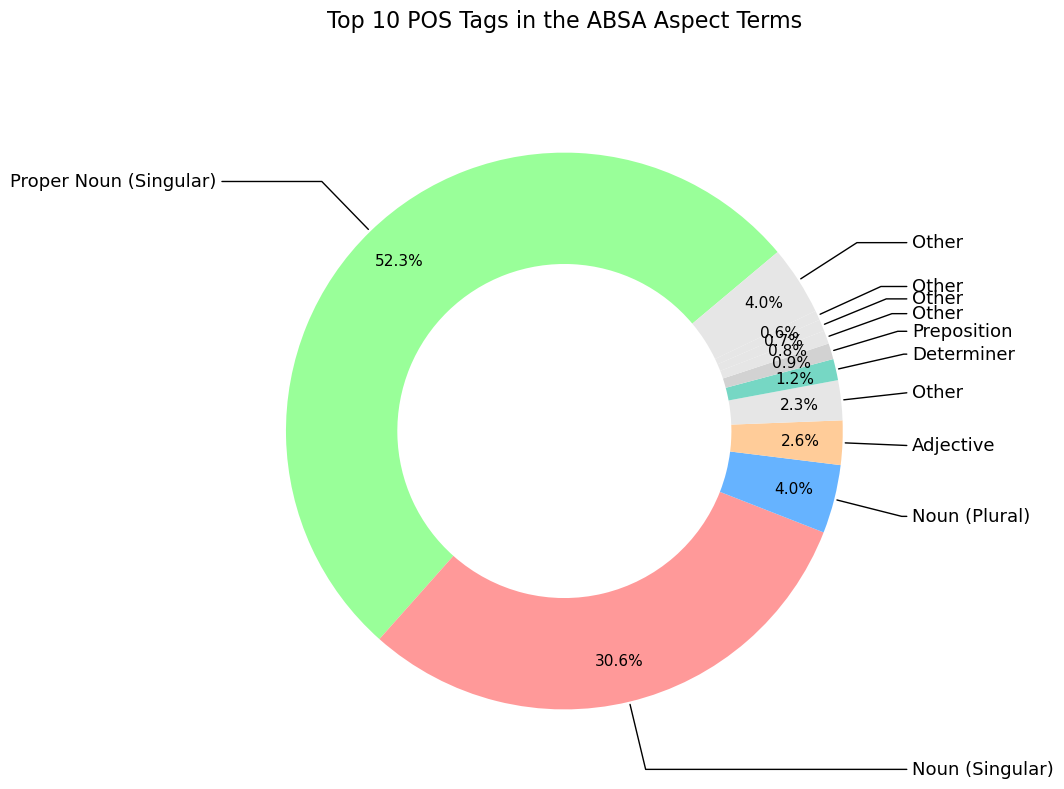

In [ ]:
pos_counts_abea = pos_stats(abea)
pos_counts_absa = pos_stats(mitchell_absa)

# for the ABEA dataset
plot_pos_distribution(pos_counts_abea, title='Top 10 POS Tags in the ABEA Aspect Terms')
plot_pos_distribution(pos_counts_absa, title='Top 10 POS Tags in the ABSA Aspect Terms')


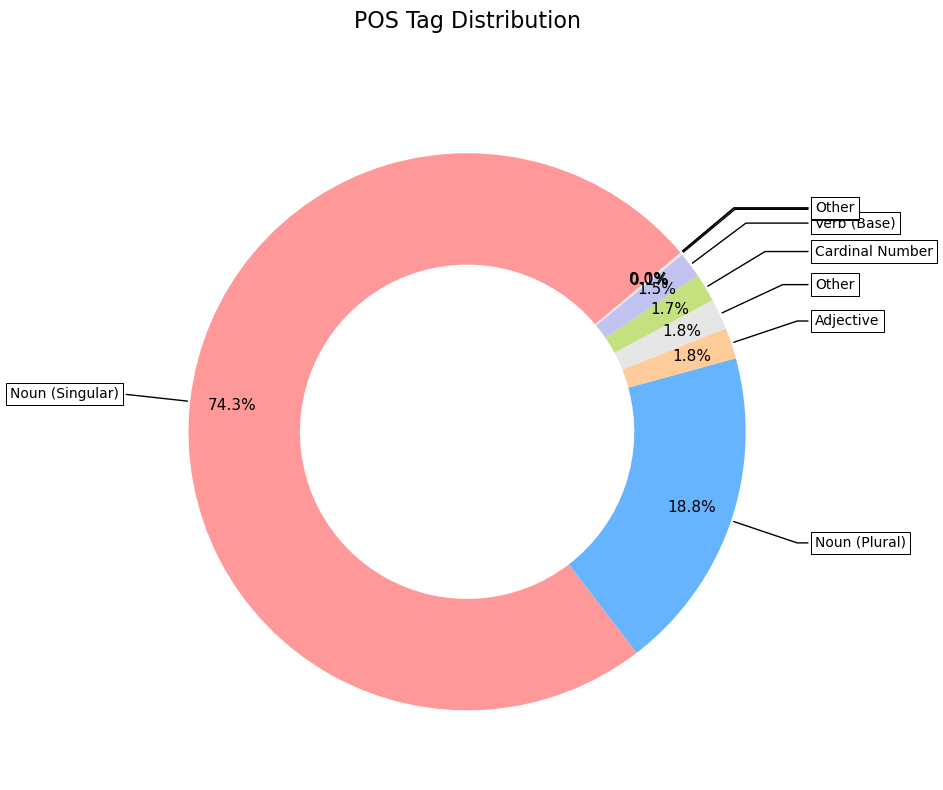

In [ ]:

def pos_stats(aspect_terms):
    pos_counts = Counter()

    for aspect_term in aspect_terms:
        # Tokenize the aspect term
        tokens = word_tokenize(aspect_term)

        # POS tagging
        tagged_tokens = nltk.pos_tag(tokens)

        # Increment count for each POS tag
        for _, tag in tagged_tokens:
            pos_counts[tag] += 1

    return pos_counts


# Mapping of POS tags to more interpretable labels
pos_labels = {
    'NN': 'Noun (Singular)',
    'NNS': 'Noun (Plural)',
    'NNP': 'Proper Noun (Singular)',
    'JJ': 'Adjective',
    'VB': 'Verb (Base)',
    'VBG': 'Verb (Gerund/Present Participle)',
    'CD': 'Cardinal Number',
    'DT': 'Determiner',
    'PRP$': 'Possessive Pronoun',
    'PRP': 'Pronoun',
    'IN': 'Preposition',
    # Add more mappings as needed
}

# Mapping of POS tags to consistent colors
pos_colors = {
    'Noun (Singular)': '#ff9999',
    'Noun (Plural)': '#66b3ff',
    'Proper Noun (Singular)': '#99ff99',
    'Adjective': '#ffcc99',
    'Verb (Base)': '#c2c2f0',
    'Verb (Gerund/Present Participle)': '#ffb3e6',
    'Cardinal Number': '#c4e17f',
    'Determiner': '#76d7c4',
    'Possessive Pronoun': '#f7dc6f',
    'Pronoun': '#e9e9e9',
    'Preposition': '#d2d2d2',
    'Other': '#e6e6e6',  # Default color for "Other"
}

def plot_pos_distribution(pos_counts, title='POS Tag Distribution', top_n=10):
    # Sort counts by most common
    sorted_counts = pos_counts.most_common()

    # Separate the top_n from the rest
    top_counts = sorted_counts[:top_n]
    other_count = sum(count for _, count in sorted_counts[top_n:])

    # Labels and values for the pie chart
    labels, values = zip(*top_counts)
    labels = [pos_labels.get(label, 'Other') for label in labels]  # Replace POS tags with interpretable labels
    labels = list(labels) + ['Other']
    values = list(values) + [other_count]

    # Assign colors based on POS tags
    colors = [pos_colors.get(label, pos_colors['Other']) for label in labels]

    # Create the pie chart with a hole in the middle for the doughnut look
    plt.figure(figsize=(10, 8))
    wedges, texts, autotexts = plt.pie(values, colors=colors, startangle=40, wedgeprops=dict(width=0.4),
                                       autopct='%1.1f%%', pctdistance=0.85)

    # Move the labels outside the pie chart
    for text in texts:
        text.set_horizontalalignment('center')
        text.set_fontsize(10)

    # Adjust label positions to avoid overlap and reduce distance
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

    for i, (wedge, label) in enumerate(zip(wedges, labels)):
        ang = (wedge.theta2 - wedge.theta1) / 2. + wedge.theta1
        y = np.sin(np.radians(ang))
        x = np.cos(np.radians(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        plt.annotate(label, xy=(x, y), xytext=(1.25*np.sign(x), 1.25*y),  # Adjust the factor (1.25) to reduce distance
                     horizontalalignment=horizontalalignment, **kw)

    plt.setp(autotexts, size=11, color="black")

    # Move the title up and increase its size
    plt.title(title, fontsize=16, pad=40)  # Increase fontsize and adjust pad for spacing
    plt.tight_layout()
    plt.show()

# Example usage with your list of aspect terms

# Get POS counts
pos_counts = pos_stats(aspect_terms_dong)

# Plot POS distribution
plot_pos_distribution(pos_counts)

### Piecharts without labels

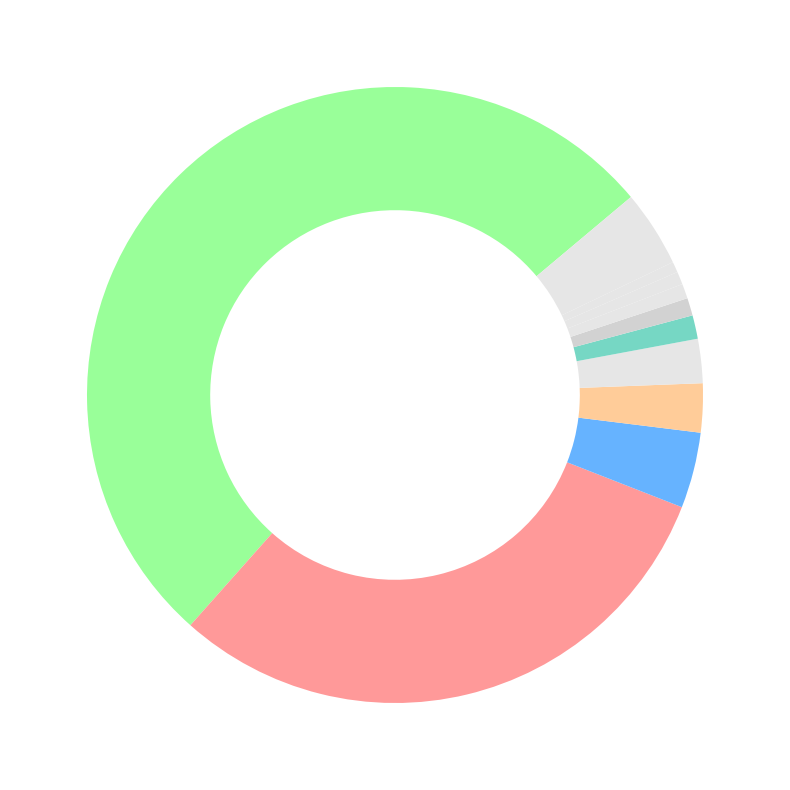

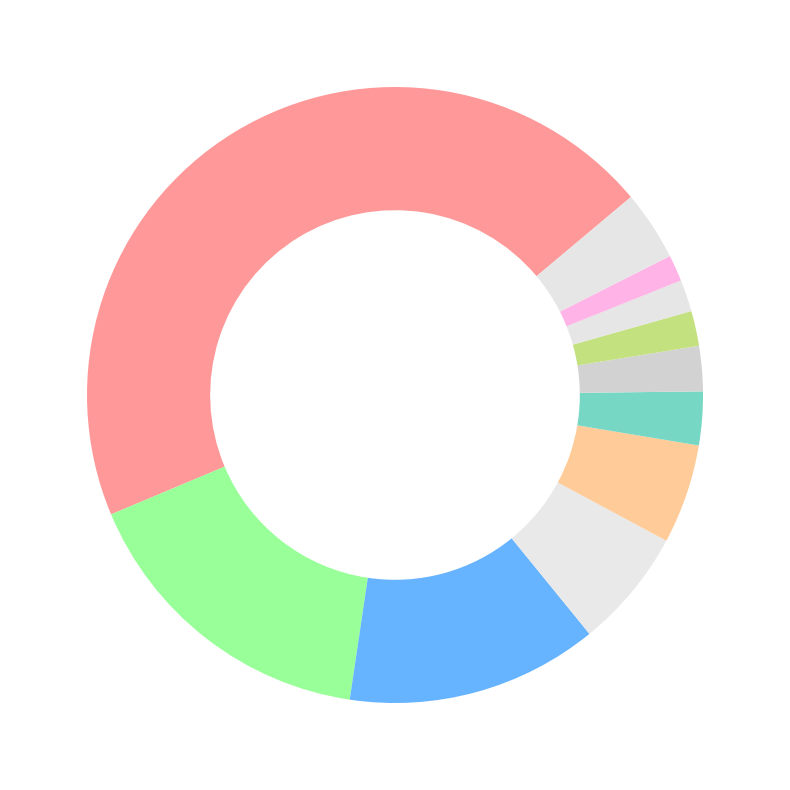

In [ ]:

def pos_stats(df):
    pos_counts = Counter()

    for _, row in df.iterrows():
        for label in row['label']:
            # Extract the aspect term using character positions
            start, end, _ = label
            aspect_term = row['text'][start:end+1]

            # Tokenize the aspect term
            tokens = word_tokenize(aspect_term)

            # POS tagging
            tagged_tokens = nltk.pos_tag(tokens)

            # Increment count for each POS tag
            for _, tag in tagged_tokens:
                pos_counts[tag] += 1

    return pos_counts

# Mapping of POS tags to more interpretable labels
pos_labels = {
    'NN': 'Noun (Singular)',
    'NNS': 'Noun (Plural)',
    'NNP': 'Proper Noun (Singular)',
    'JJ': 'Adjective',
    'VB': 'Verb (Base)',
    'VBG': 'Verb (Gerund/Present Participle)',
    'CD': 'Cardinal Number',
    'DT': 'Determiner',
    'PRP$': 'Possessive Pronoun',
    'PRP': 'Pronoun',
    'IN': 'Preposition',
    # Add more mappings as needed
}

# Mapping of POS tags to consistent colors
pos_colors = {
    'Noun (Singular)': '#ff9999',
    'Noun (Plural)': '#66b3ff',
    'Proper Noun (Singular)': '#99ff99',
    'Adjective': '#ffcc99',
    'Verb (Base)': '#c2c2f0',
    'Verb (Gerund/Present Participle)': '#ffb3e6',
    'Cardinal Number': '#c4e17f',
    'Determiner': '#76d7c4',
    'Possessive Pronoun': '#f7dc6f',
    'Pronoun': '#e9e9e9',
    'Preposition': '#d2d2d2',
    'Other': '#e6e6e6',  # Default color for "Other"
}

def plot_pos_distribution(pos_counts, top_n=10):
    # Sort counts by most common
    sorted_counts = pos_counts.most_common()

    # Separate the top_n from the rest
    top_counts = sorted_counts[:top_n]
    other_count = sum(count for _, count in sorted_counts[top_n:])

    # Labels and values for the pie chart
    labels, values = zip(*top_counts)
    labels = [pos_labels.get(label, 'Other') for label in labels]  # Replace POS tags with interpretable labels
    labels = list(labels) + ['Other']
    values = list(values) + [other_count]

    # Assign colors based on POS tags
    colors = [pos_colors.get(label, pos_colors['Other']) for label in labels]

    # Create the pie chart with a hole in the middle for the doughnut look
    plt.figure(figsize=(10, 8))
    wedges, _, autotexts = plt.pie(values, colors=colors, startangle=40, wedgeprops=dict(width=0.4),
                                   autopct=lambda p: f'{p:.1f}%' if p > 60 else '', pctdistance=0.85)

    # Move the labels outside the pie chart
    for text in autotexts:
        text.set_horizontalalignment('center')
        text.set_fontsize(10)

    plt.tight_layout()
    plt.show()

# Example usage
pos_counts = pos_stats(mitchell_absa)
plot_pos_distribution(pos_counts)

pos_counts_abea = pos_stats(abea)
plot_pos_distribution(pos_counts_abea)

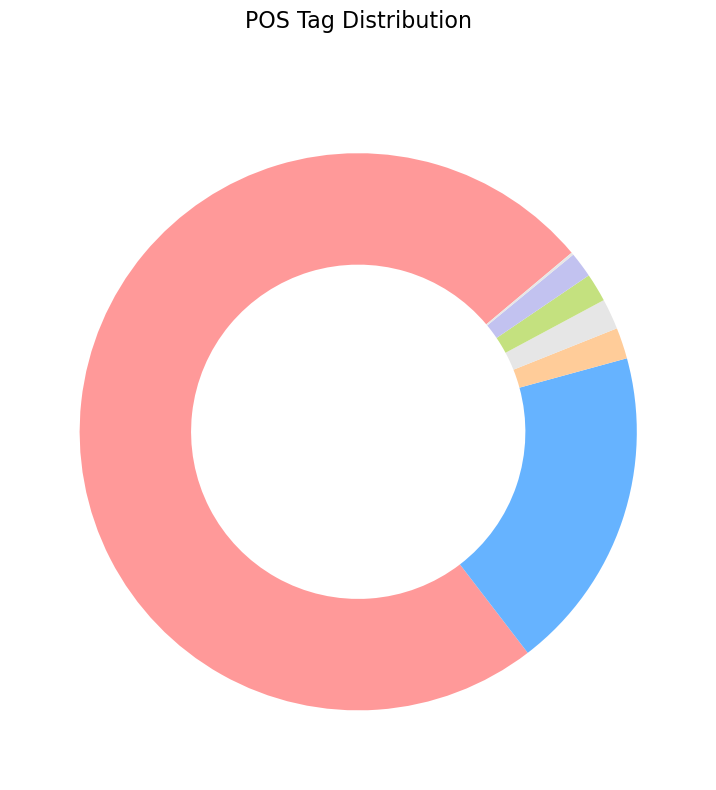

In [ ]:

def pos_stats(aspect_terms):
    pos_counts = Counter()

    for aspect_term in aspect_terms:
        # Tokenize the aspect term
        tokens = word_tokenize(aspect_term)

        # POS tagging
        tagged_tokens = nltk.pos_tag(tokens)

        # Increment count for each POS tag
        for _, tag in tagged_tokens:
            pos_counts[tag] += 1

    return pos_counts

# Mapping of POS tags to more interpretable labels
pos_labels = {
    'NN': 'Noun (Singular)',
    'NNS': 'Noun (Plural)',
    'NNP': 'Proper Noun (Singular)',
    'JJ': 'Adjective',
    'VB': 'Verb (Base)',
    'VBG': 'Verb (Gerund/Present Participle)',
    'CD': 'Cardinal Number',
    'DT': 'Determiner',
    'PRP$': 'Possessive Pronoun',
    'PRP': 'Pronoun',
    'IN': 'Preposition',
    # Add more mappings as needed
}

# Mapping of POS tags to consistent colors
pos_colors = {
    'Noun (Singular)': '#ff9999',
    'Noun (Plural)': '#66b3ff',
    'Proper Noun (Singular)': '#99ff99',
    'Adjective': '#ffcc99',
    'Verb (Base)': '#c2c2f0',
    'Verb (Gerund/Present Participle)': '#ffb3e6',
    'Cardinal Number': '#c4e17f',
    'Determiner': '#76d7c4',
    'Possessive Pronoun': '#f7dc6f',
    'Pronoun': '#e9e9e9',
    'Preposition': '#d2d2d2',
    'Other': '#e6e6e6',  # Default color for "Other"
}

def plot_pos_distribution_no_labels(pos_counts, title='POS Tag Distribution', top_n=10):
    # Sort counts by most common
    sorted_counts = pos_counts.most_common()

    # Separate the top_n from the rest
    top_counts = sorted_counts[:top_n]
    other_count = sum(count for _, count in sorted_counts[top_n:])

    # Labels and values for the pie chart
    labels, values = zip(*top_counts)
    labels = [pos_labels.get(label, 'Other') for label in labels]  # Replace POS tags with interpretable labels
    values = list(values) + [other_count]

    # Assign colors based on POS tags
    colors = [pos_colors.get(label, pos_colors['Other']) for label in labels]

    # Create the pie chart with a hole in the middle for the doughnut look
    plt.figure(figsize=(10, 8))
    wedges, _, autotexts = plt.pie(values, colors=colors, startangle=40, wedgeprops=dict(width=0.4),
                                   autopct=lambda p: f'{p:.1f}%' if p > 80 else '', pctdistance=0.85)

    # Move the title up and increase its size
    plt.title(title, fontsize=16, pad=40)
    plt.tight_layout()
    plt.show()

# Get POS counts
pos_counts = pos_stats(aspect_terms_dong)

# Plot POS distribution without labels
plot_pos_distribution_no_labels(pos_counts)